<a href="https://colab.research.google.com/github/IT21161056/Papaya-Buddy/blob/pasindu/CNN_papaya_RePr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Imports required for model

In [ ]:
import os
import time
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Flatten,
    Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

3. GPU optimization

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


4. Track the model performace

In [ ]:
class ModelPerformanceTracker:
    def __init__(self):
        self.metrics = {}

    def track(self, metric_name, value):
        self.metrics[metric_name] = value

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, class_names):
        super().__init__()
        self.val_ds = validation_data
        self.class_names = class_names
        self.epoch_metrics = []  # To store metrics for all epochs

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_metrics.append({
            'epoch': epoch + 1,
            'training_loss': logs.get('loss'),
            'validation_loss': logs.get('val_loss'),
            'training_accuracy': logs.get('accuracy'),
            'validation_accuracy': logs.get('val_accuracy'),
        })

5. Dataset preparation

In [ ]:
def prepare_dataset(data_dir, img_height=256, img_width=256, batch_size=16):
    # Load the full dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(img_height, img_width),
        batch_size=None,
        shuffle=True,
        seed=42
    )

    # Get dataset size and class names
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    class_names = dataset.class_names

    # Calculate split sizes
    train_size = int(0.7 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split dataset
    train_ds = dataset.take(train_size)
    temp_ds = dataset.skip(train_size)
    val_ds = temp_ds.take(val_size)
    test_ds = temp_ds.skip(val_size)

    def configure_for_performance(ds, batch_size=16, shuffle_buffer=1000):
        ds = ds.cache()
        ds = ds.shuffle(buffer_size=shuffle_buffer)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
        return ds

    def normalize_img(image, label):
        return tf.cast(image, tf.float32) / 255., label

    # Apply configurations
    train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

    train_ds = configure_for_performance(train_ds, batch_size)
    val_ds = configure_for_performance(val_ds, batch_size)
    test_ds = configure_for_performance(test_ds, batch_size)

    print(f"Total dataset size: {dataset_size}")
    print(f"Training samples: {train_size}")
    print(f"Validation samples: {val_size}")
    print(f"Test samples: {test_size}")

    return train_ds, val_ds, test_ds, class_names

6. CNN model architecture

In [ ]:
def build_cnn(input_shape, num_classes):
    """Build the CNN model."""
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D(),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.summary()
    return model

7. Plot diagrams

In [ ]:
def plot_training_history(history, save_path):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

8. Write metrics to csv file

In [ ]:
def write_metrics_to_csv(metrics_callback, save_path):
    # Create a DataFrame from the collected epoch metrics
    df = pd.DataFrame(metrics_callback.epoch_metrics)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save to CSV
    df.to_csv(save_path, index=False)
    print(f"Metrics saved to {save_path}")

9. Main function

In [ ]:
def main():

    performance_tracker = ModelPerformanceTracker()

    # Set data directory and parameters
    data_dir = '/content/drive/My Drive/cnnpapayarpd/images_cnn'
    img_height, img_width = 256, 256
    batch_size = 16

    # Prepare datasets
    train_ds, val_ds, test_ds, class_names = prepare_dataset(
        data_dir, img_height, img_width, batch_size
    )

    # Model Configuration
    input_shape = (img_height, img_width, 3)
    num_classes = len(class_names)
    model = build_cnn(input_shape, num_classes)

    # Initialize MetricsCallback
    metrics_callback = MetricsCallback(val_ds, class_names)

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Training
    start_time = time.time()
    history = model.fit(
        train_ds,
        epochs=30,
        validation_data=val_ds,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=20),
            metrics_callback
        ]
    )
    end_time = time.time()

    performance_tracker.track('training_time', end_time - start_time)

    # Save Paths
    base_save_path = '/content/drive/My Drive/cnnpapayarpd/cnn_run2'
    os.makedirs(base_save_path, exist_ok=True)

    # Save Model
    model.save(os.path.join(base_save_path, 'papaya_disease_model.h5'))

    metrics_path = os.path.join(base_save_path, 'metrics.csv')
    write_metrics_to_csv(metrics_callback, metrics_path)

    # Evaluate on Test Set
    test_predictions = []
    test_labels = []
    for images, labels in test_ds:
        predictions = model.predict(images)
        test_predictions.extend(np.argmax(predictions, axis=1))
        test_labels.extend(labels.numpy())

    # Plot Confusion Matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Test Set)')
    plt.colorbar()
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white")

    plt.tight_layout()
    plt.savefig(os.path.join(base_save_path, 'confusion_matrix.png'))
    plt.close()

    train_accuracy = history.history['accuracy'][-1]
    val_accuracy = history.history['val_accuracy'][-1]

    print(f"\nOverall Training Accuracy: {train_accuracy:.4f}")
    print(f"Overall Validation Accuracy: {val_accuracy:.4f}")

    plot_training_history(history, os.path.join(base_save_path ,'training_history.png'))

    return performance_tracker.metrics

if __name__ == '__main__':
    drive.mount('/content/drive')
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1500 files belonging to 3 classes.
Total dataset size: 1500
Training samples: 1050
Validation samples: 300
Test samples: 150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,445,443 (32.22 MB)

 Trainable params: 8,445,443 (32.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 1048s 7s/step - accuracy: 0.4141 - loss: 1.0853 - val_accuracy: 0.6333 - val_loss: 0.8355
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 35ms/step - accuracy: 0.6939 - loss: 0.7431 - val_accuracy: 0.8400 - val_loss: 0.4661
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7917 - loss: 0.5262 - val_accuracy: 0.8533 - val_loss: 0.3625
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8739 - loss: 0.3614 - val_accuracy: 0.9233 - val_loss: 0.2488
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8775 - loss: 0.3425 - val_accuracy: 0.9167 - val_loss: 0.2258
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8798 - loss: 0.3293 - val_accuracy: 0.9333 - val_loss: 0.1902
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9121 - loss: 0.2622 - val_accuracy: 0.9600 - val_loss: 0.1594
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9083 - loss: 0.2339 - val_accuracy: 0.9633 -

Metrics saved to /content/drive/My Drive/cnnpapayarpd/cnn_run2/metrics.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Overall Training Accuracy: 0.9867
Overall Validation Accuracy: 0.9767


10. Model validation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


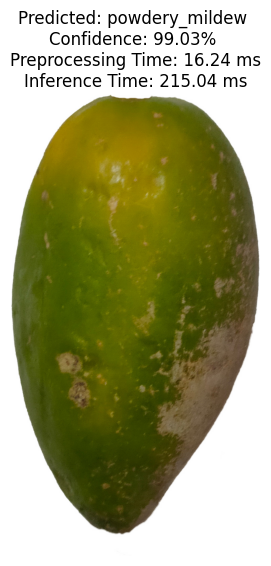

Preprocessing Time: 16.24 ms
Inference Time: 215.04 ms


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import time

# Define file paths
model_path = '/content/drive/My Drive/cnnpapayarpd/cnn_run2/papaya_disease_model.h5'
test_image_path = '/content/drive/My Drive/cnnpapayarpd/testcnn_image/test_pw.jpg'

# Load the trained model
model = tf.keras.models.load_model(model_path)

class_names = ['healthy', 'powdery_mildew', 'ringspot']

# Load and preprocess the test image
img_height, img_width = 256, 256

# Measure preprocessing time
start_preprocess_time = time.time()
image = load_img(test_image_path, target_size=(img_height, img_width))
image_array = img_to_array(image) / 255.0  # Normalize the image
image_array = np.expand_dims(image_array, axis=0)
preprocess_time = (time.time() - start_preprocess_time) * 1000  # Calculate preprocessing time in ms

# Measure inference time
start_inference_time = time.time()
predictions = model.predict(image_array)
inference_time = (time.time() - start_inference_time) * 1000  # Calculate inference time in ms

predicted_class = np.argmax(predictions, axis=1)[0]
confidence_score = predictions[0][predicted_class]  # Get the confidence score for the predicted class

result_image_path = f'/content/drive/MyDrive/testcnn/results{class_names[predicted_class]}_predicted.jpg'

plt.figure(figsize=(6, 6))
plt.imshow(load_img(test_image_path))
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} \nConfidence: {confidence_score*100:.2f}% \n"
          f"Preprocessing Time: {preprocess_time:.2f} ms\nInference Time: {inference_time:.2f} ms")
plt.show()
# plt.savefig(result_image_path)
# plt.close()

print(f"Preprocessing Time: {preprocess_time:.2f} ms")
print(f"Inference Time: {inference_time:.2f} ms")